# Abstract

This is a "quick look" test report that determines the capacity of batteries under repetitive charge and discharge cycles (CC/CV). This report reads the test files from the Data folder and performs some EDA on the data. 

In [32]:
# Bring in the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter

## Data Cleaning Routine

The files need to be cleaned prior to analyzing. The following routine cleans up the files. The cleanup actions are routine:

* The data was grabbed for me by another engineer. 
* In general, the files contain multiple charge/discharge cycles. I have selected the third cycle (c == 3). I could average the cycles, but they are generally so similar that it is not worth it.
* Each charge/discharge cycle contains multiple stages. Stage 4 is the discharge cycle.

For a reason unknown to me, the CV=4.15V data had a different output format. So I wrote two different cleaning routine. I distinguished the files by call the CV=4.15 data "csv" and the others "txt".


### Clean CSV Files

While I call these CSV files, they actually are tab separated just like the other files. I gave them this name so that I could distinguish their format from the others. I wish I knew why the format was different, but it was. The key format difference is that the step time is in minutes rather than encoded in a string.

In [33]:
def batTweak1(file):
    return (
        pd.read_csv(file, sep="\t",skiprows=4, header=0,usecols=["Cyc#","Step","StepTime","Amps","Volts"])
        .rename({"Volts":"v","Cyc#":"c","StepTime":"t"}, axis=1)
        .query("c == 2 &  Step==5")
        .drop(["Step","Amps","c"],axis=1)
        .assign(q = lambda x: x.t*0.5/60,
                t = lambda x: x.t/60)
    )

### Clean TXT Files

These are tab separated files that have step time encoded as an odd-ball date/time string.

In [34]:
def batTweak(file):
    return (
        pd.read_csv(file, sep="\t",skiprows=4, header=0,usecols=["Cyc#","Step","StepTime","Amps","Volts"])
        .rename({"Volts":"v","Cyc#":"c"}, axis=1)
        .assign(days = lambda x: x.StepTime.str.extract("(.+?)d"),
                hours= lambda x: x.StepTime.str.extract("(?<=d)(.*)"))
        .assign(h =    lambda x: x.hours.str.extract("(\d*)(?=:)"),
                m =    lambda x: x.hours.str.extract("(?<=:)(\d*)"),
                s =    lambda x: x.hours.str.extract("(?<=:\d\d:)(.*)"))
        .drop(["hours","StepTime","hours"],axis=1)
        .astype({"days":"float64","h":"float64","m":"float64","s":"float64"})
        .assign(t = lambda x: x.days*1440+x.h*60+x.m+x.s/60)
        .drop(["h","m","s","days"],axis=1)
        .query("c == 2 &  Step==5")
        .drop(["Step","Amps","c"],axis=1)
        .assign(q = lambda x: x.t*0.5/60,
                t = lambda x: x.t/60)
    )

## Read the TXT Files and Clean

Here we iterate through all the TXT files.

In [35]:
### Utility File Reader

def file_getter(f,g):
    z = pd.DataFrame() # Create an empty dataframe
    for f in files:
        df = g(f)
        unit = re.search("(?<=_U)\w{2}",f).group(0)
        model = re.search("(?<=_M)\w{4}",f).group(0)
        fctr = re.search("(?<=_D)\w{3}",f).group(0)
        df = df.assign(Unit = "U"+unit,
                       Model= model,
                       CV = fctr)
        vc = int(fctr)/100
        new_row = pd.DataFrame({'v':vc, 't':0, 'q':0,'Unit':'U'+unit,"Model":model,"CV":fctr}, index=[0])
        df=pd.concat([new_row,df.loc[:]]).reset_index(drop=True)
        z = pd.concat([z,df])
    return z.reset_index(drop=True)
    

In [36]:
files=glob.glob("./Z02_Test/*.txt",recursive=False)
z=file_getter(files,batTweak)
print(z[(z['CV']=='430')&(z['Unit']=='U01')])
files=glob.glob("./Z02_Test/*.csv",recursive=False)
z1=file_getter(files,batTweak1)
z  = (pd.concat([z,z1])
      .sort_values(by=['CV'])
      .reset_index(drop=True)
     )

            v          t          q Unit Model   CV
2642  4.30000   0.000000   0.000000  U01  Z02F  430
2643  4.28771   0.000003   0.000001  U01  Z02F  430
2644  4.27909   0.016669   0.008335  U01  Z02F  430
2645  4.27703   0.033336   0.016668  U01  Z02F  430
2646  4.27550   0.050003   0.025001  U01  Z02F  430
...       ...        ...        ...  ...   ...  ...
4062  3.13466  23.650003  11.825001  U01  Z02F  430
4063  3.10544  23.666669  11.833335  U01  Z02F  430
4064  3.07111  23.683336  11.841668  U01  Z02F  430
4065  3.02876  23.700003  11.850001  U01  Z02F  430
4066  3.00000  23.709322  11.854661  U01  Z02F  430

[1425 rows x 6 columns]


# Extract-Transform-Load

Once cleaned, the data is in the correct format but needs to be augmented with information on the unit-under-test (UUT) and battery model info. This data can be extracted from the file name, which has the following format.
<pre><code>
 (tester initials: 2 char)_U(unit number: 2 char)_M(model: 4 characters)_D(test description:any length, spaces=dashes)
</code></pre>
I do not like spaces in file names and I decided that topics are separated by underscores and spaces replaced with dashes. I can illustrate this format as follows:
<pre><code>
MB_U02_MZ22A_DLong-Test-4-1-CV-CH17.txt
</code></pre>

The file information tells us that:

* Tester initials: MB
* Unit Under Test: 02
* Model Under Test: Z22A
* Test Description: Long Test 4.1 CV Channel 17

# Exploratory Data Analysis

The capacity value and the State of Charge (SoC) curve are all derived from the discharge curve, which is what the Maccor battery tester measures. The discharge curve for all the parts is shown below.

In [37]:
print(z.columns)
z.sort_values(by=["Unit","v"],ascending=False,inplace=True)
print(z[z['CV']=='430'])

Index(['v', 't', 'q', 'Unit', 'Model', 'CV'], dtype='object')
             v          t          q Unit Model   CV
9053   4.30000   0.000000   0.000000  U03  Z02F  430
9054   4.28519   0.000011   0.000006  U03  Z02F  430
9055   4.28031   0.016678   0.008339  U03  Z02F  430
9056   4.27810   0.033344   0.016672  U03  Z02F  430
9057   4.27672   0.050011   0.025006  U03  Z02F  430
...        ...        ...        ...  ...   ...  ...
11242  3.13466  23.650003  11.825001  U01  Z02F  430
11243  3.10544  23.666669  11.833335  U01  Z02F  430
11244  3.07111  23.683336  11.841668  U01  Z02F  430
11245  3.02876  23.700003  11.850001  U01  Z02F  430
11246  3.00000  23.709322  11.854661  U01  Z02F  430

[4297 rows x 6 columns]


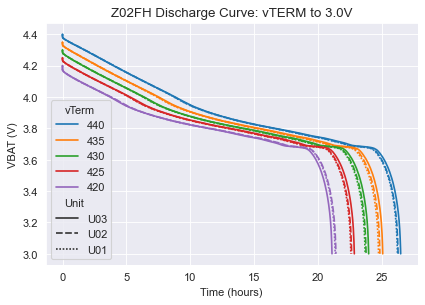

In [71]:
# View the Maccor Capacity Results
z= z.assign(vTerm=z.CV)
zz = z.groupby(["Unit","vTerm"])

# Plot the Discharge Curve

from matplotlib.pyplot import figure
figure(figsize=(6, 4), dpi=80)
sns.set_style("darkgrid")

fig = sns.lineplot(
            x='t', 
            y='v',
            hue='vTerm',
            style='Unit',
            data=z)

plt.xlabel("Time (hours)")
plt.ylabel("VBAT (V)")
plt.title("Z02FH Discharge Curve: vTERM to 3.0V")
plt.show(fig)

# Battery Capacity - Vendor Voltage Range

The battery capacities measured during this testing are computed below.

## Individual Battery Capacities

In [66]:
g1 = np.round(z.groupby( ["vTerm","Unit"] ).max(),2)
display(g1)

v      t      q Model   CV
vTerm Unit                               
420   U01   4.20  21.36  10.68  Z02F  420
      U02   4.20  21.42  10.71  Z02F  420
      U03   4.20  21.11  10.56  Z02F  420
425   U01   4.25  22.59  11.30  Z02F  425
      U02   4.25  22.65  11.32  Z02F  425
      U03   4.25  22.86  11.43  Z02F  425
430   U01   4.30  23.71  11.85  Z02F  430
      U02   4.30  23.78  11.89  Z02F  430
      U03   4.30  23.99  11.99  Z02F  430
435   U01   4.35  24.76  12.38  Z02F  435
      U02   4.35  24.87  12.43  Z02F  435
      U03   4.35  25.09  12.54  Z02F  435
440   U01   4.40  26.24  13.12  Z02F  440
      U02   4.40  26.29  13.15  Z02F  440
      U03   4.40  26.49  13.25  Z02F  440

In [40]:

# https://stackoverflow.com/questions/53062000/how-to-set-the-precision-for-the-output-of-the-pandas-dataframe-loc-in-a-jupyter
# https://stackoverflow.com/questions/42576491/python3-pandas-styles-change-alternate-row-color
# I have not been able to set the precision for each column independently

def dfdark(styler):
    #styler.background_gradient(cmap='coolwarm')
    #styler.color('white')
    styler.set_table_styles([
        {
            "selector":"thead",
            "props":[("background-color","tan")]
        },
        {
            "selector":"tbody tr:nth-child(even)",
            "props":[("background-color","navajowhite")]
        },
        {
            "selector":"th.row_heading",
            "props":[("background-color","beige")]
        },
        {
            "selector":"td",
            "props":[("border","white")]
        }
    ])
    return styler

with pd.option_context('display.precision', 2):
     style = g1.style.pipe(dfdark)
display(style)

## Aggregated Results

The means of the measured values can be computed as follows.

In [67]:
g1 = z.groupby( ["vTerm","Unit"] ).max()
gzz= (g1.groupby(['vTerm'])
      .mean()
      .set_index(['v'],drop=True)
      .rename(columns={"t":"Time (h)","q":"Charge (mAh)"})
      .rename_axis("Voltage", axis=0)
     )

with pd.option_context('display.precision', 2):
    style = gzz.style.pipe(dfdark)
style


,Time (h),Charge (mAh)
Voltage,,
4.2,21.30,10.65
4.25,22.70,11.35
4.3,23.83,11.91
4.35,24.91,12.45
4.4,26.34,13.17


## Pivot Table Form

You can generate the same result using a pivot table. I just use this here as a cross-check.

In [42]:
g2=(g1
    .pivot_table(values=['q','t'],index=["CV"],aggfunc=np.mean)
    .rename(columns={"t":"Time (h)","q":"Charge (mAh)"}, \
            index =  {'420':4.20,'430':4.30,'435':4.35,'425':4.25,'440':4.40})
    .rename_axis('Termination Voltage')
   )

with pd.option_context('display.precision', 2):
    style = g2.style.pipe(dfdark)
style


,Charge (mAh),Time (h)
Termination Voltage,,
4.2,10.65,21.30
4.25,11.35,22.70
4.3,11.91,23.83
4.35,12.45,24.91
4.4,13.17,26.34


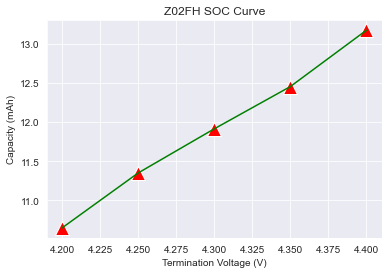

In [43]:
plt.figure(figsize=(6,4))
g2['x']=g2.index
sns.lineplot(x = 'x', y = 'Charge (mAh)', color='green',data = g2)
sns.scatterplot(x = 'x', y = 'Charge (mAh)', data = g2, s =200, marker='^',color='red')
plt.title("Capacity versus Termination Voltage")
plt.xlabel("Termination Voltage (V)")
plt.ylabel("Capacity (mAh)")
plt.title("Z02FH SOC Curve")
None

# Battery Capacity - Starkey Voltage Range

In [44]:
# It is important to understand the impact of the low battery voltage on the battery capacity.
vLow=3*1.16              # The VHA side low battery threshold is 1.16 V, so 3*1.16 on the battery side of the HPM10
tLowBat=34/60            # I need the low battery wait time in hours. 4 minutes persistenace + 30 minutes wait.
iDischarge=0.36          # My estimate of the discharge current for the CIC nominal current
qFix=tLowBat*iDischarge  # Here is the charge transferred during the low battery interval

from scipy.interpolate import interp1d
vy = pd.DataFrame({'CV':[],'q':[]})
for y in z['CV'].unique():
    vx = []
    for x in z['Unit'].unique():
        interp_func = interp1d(z.query(f"Unit=='{x}' & CV=='{y}'").v, z.query(f"Unit=='{x}' & CV=='{y}'").q)
        qx = interp_func(vLow)
    vy =vy.append({'CV':y,'q':qx+qFix},ignore_index=True)

    gzzz= (vy
      .set_index(['CV'],drop=True)
      .rename(columns={"q":"Charge (mAh)"},index={'420':'4.20','430':'4.30','435':'4.35', '425':'4.25', '440':'4.40'})
      .rename_axis("Voltage", axis=0)
     )

with pd.option_context('display.precision', 2):
    style = gzzz.sort_index().style.pipe(dfdark)
style

,Charge (mAh)
Voltage,
4.20,10.54
4.25,11.16
4.30,11.72
4.35,12.24
4.40,12.98


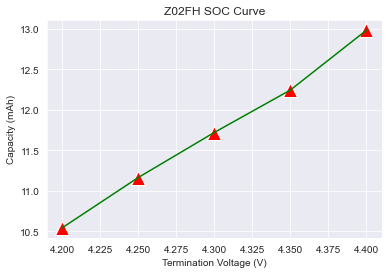

In [45]:
plt.figure(figsize=(6,4))

z222 = {'4.20':4.20,'4.25':4.25,'4.30':4.30,'4.35':4.35,'4.40':4.40}
gzzz['x']=gzzz.index.map(z222)

sns.lineplot(x = 'x', y = 'Charge (mAh)', color='green',data = gzzz)
sns.scatterplot(x = 'x', y = 'Charge (mAh)', data = gzzz, s =200, marker='^',color='red')
plt.title("Capacity versus Termination Voltage")
plt.xlabel("Termination Voltage (V)")
plt.ylabel("Capacity (mAh)")
plt.title("Z02FH SOC Curve")
None

# SOC Curves

## Generate SOC Curves for Each UUT

In [46]:
vendor=pd.DataFrame({"soc" :[100,99.9,95,90,85,80,75,70,65,60,55,50,40,35,30,25,20,15,10,5,3,2,1,0],
                    "VBAT":[4.2,4.18,4.125,4.08,4.039,4,3.965,3.931,3.897,3.86,3.835,3.817,3.788,3.775,3.758,3.74,3.721,3.691,3.679,3.595,3.49,3.41,3.3,3
]}
)
vendor["Unit"]="Z22A"
vendor['SOC']=0.01*vendor.soc
print(vendor)


r = pd.DataFrame()
for v in z['CV'].unique():
    for u in z['Unit'].unique():
        s = z.query(f"Unit=='{u}' & CV=='{v}'")
        s=s.sort_values(by=['t'])
        m = s['q'].max()
        s=s.assign(soc = 1-s['q']/m)
        r = pd.concat([r,s])
        
r=r.rename(columns={"v":"VBAT","soc":"SOC"})

      soc   VBAT  Unit    SOC
0   100.0  4.200  Z22A  1.000
1    99.9  4.180  Z22A  0.999
2    95.0  4.125  Z22A  0.950
3    90.0  4.080  Z22A  0.900
4    85.0  4.039  Z22A  0.850
5    80.0  4.000  Z22A  0.800
6    75.0  3.965  Z22A  0.750
7    70.0  3.931  Z22A  0.700
8    65.0  3.897  Z22A  0.650
9    60.0  3.860  Z22A  0.600
10   55.0  3.835  Z22A  0.550
11   50.0  3.817  Z22A  0.500
12   40.0  3.788  Z22A  0.400
13   35.0  3.775  Z22A  0.350
14   30.0  3.758  Z22A  0.300
15   25.0  3.740  Z22A  0.250
16   20.0  3.721  Z22A  0.200
17   15.0  3.691  Z22A  0.150
18   10.0  3.679  Z22A  0.100
19    5.0  3.595  Z22A  0.050
20    3.0  3.490  Z22A  0.030
21    2.0  3.410  Z22A  0.020
22    1.0  3.300  Z22A  0.010
23    0.0  3.000  Z22A  0.000


## Graph SOC from 3.0 V to 4.2 V

The vendor's normally rate their batteries from 3.0 V to 4.2 V. There are two batteries under test. The following plot shows an overplot of the two curves. As you can see, the two devices are very consistent. Normally, I average the two curves. In this case, there is no need to average because they are so similar.

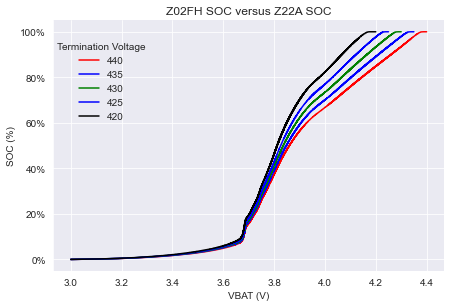

In [47]:
import matplotlib.ticker as tkr
df3 = pd.concat([r,vendor]).reset_index(drop=True)
ax=sns.relplot(x = df3.VBAT, y = df3.SOC, hue=df3.CV, palette = ['red', 'blue','green','blue','black'],kind="line", \
              height=4, aspect=6/4)
ax.set(title='Z02FH SOC versus Z22A SOC',ylabel="SOC (%)",xlabel="VBAT (V)")
for a in ax.axes.flat:
    a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y:.0%}'))
leg = ax._legend
leg.set_title("Termination Voltage")
leg.set_bbox_to_anchor([0.10, 0.95])
leg._loc = 2 
plt.show()



<Figure size 432x288 with 0 Axes>

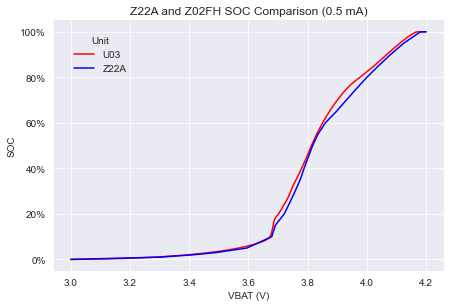

In [73]:
df4=df3.copy()
df4=df4.query("Unit=='U03' and CV=='420'")
df4=df4[['VBAT','SOC',"Unit"]]
df5 = pd.concat([df4, vendor], ignore_index=True)
plt.figure(figsize=(6,4))
g = (sns.relplot(data=df5, x='VBAT', y='SOC', kind='line', hue='Unit', palette=['red', 'blue'], height=4, aspect=6/4)
     .set(title='Z22A and Z02FH SOC Comparison (0.5 mA)',xlabel='VBAT (V)',ylabel='SOC')
    )
leg = g._legend
leg.set_bbox_to_anchor([0.275, 0.875])  # coordinates of lower left of bounding box
next(g.axes.flat).yaxis.set_major_formatter(PercentFormatter(1))

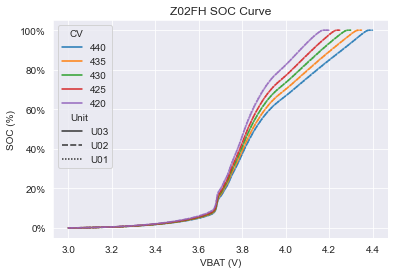

In [49]:

plt.figure(figsize=(6,4))
g=sns.lineplot(
                     x=r.VBAT,
                     y=r.SOC*100,
                     style=r.Unit,
                     hue=r.CV,
                     alpha=0.6
)
g.yaxis.set_major_formatter(PercentFormatter())
g.set_title("SOC Overplot")
plt.xlabel("VBAT (V)")
plt.ylabel("SOC (%)")
plt.title("Z02FH SOC Curve")
None

## Single Graph SOC Overplot

I simply filtered for one unit and plotted all the SOCs on one plot. 

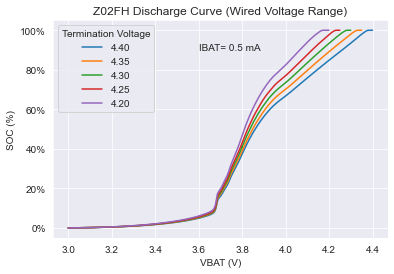

In [50]:
# These are close enough that I don't need to average them. I will just overplot.
r1 = r.query("Unit=='U01'").assign(SOC = lambda x: x.SOC*100)
plt.figure(figsize=(6,4))
g = sns.lineplot(data=r1,x='VBAT', y='SOC',hue='CV')
g.yaxis.set_major_formatter(PercentFormatter())
g.set_title("Z02FH Discharge Curve (Wired Voltage Range)")
plt.xlabel("VBAT (V)")
plt.ylabel("SOC (%)")
plt.legend(title='Termination Voltage', loc='upper left', labels=['4.40','4.35', '4.30', '4.25','4.20'])
g.text(3.6, 90, "IBAT= 0.5 mA")
None

## SOC from 3.414 V to 4.2 V

This is the SOC we would use in our application.

In [51]:
from scipy import interpolate
n = r1[r1['VBAT']>3.414]
y1 = pd.DataFrame()
for u in n.CV.unique():
    x = n[n['CV']==u]
    socmin=x['SOC'].min()
    f1 = interpolate.interp1d(x.VBAT, x.t, fill_value='extrapolate')
    g1 = interpolate.interp1d(x.VBAT, x.q, fill_value='extrapolate')
    new_row = pd.DataFrame({'SOC':0,'VBAT':3.414, 't':f1(3.414), 'q':g1(3.414),'Unit':'U01',"Model":"Z22A","CV":u}, index=[0])
    x=x.assign(SOC = lambda x: (x.SOC-socmin)/(100-socmin))
    x=pd.concat([x.loc[:],new_row])
    y1 = pd.concat([y1,x]).reset_index(drop=True)

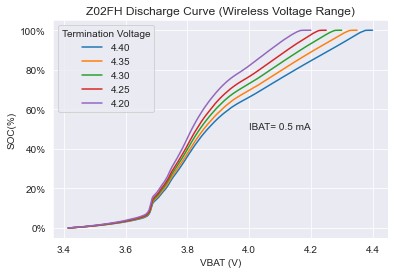

In [52]:
sns.set_style("darkgrid")
plt.figure(figsize=(6,4))
y1.SOC = y1.SOC*100
fig = sns.lineplot(
            x='VBAT', 
            y='SOC',
            hue='CV', 
            data=y1)
fig.yaxis.set_major_formatter(PercentFormatter())
plt.xlabel("VBAT (V)")
plt.ylabel("SOC(%)")
plt.title("Z02FH Discharge Curve (Wireless Voltage Range)")
plt.legend(title='Termination Voltage', loc='upper left', labels=['4.40','4.35', '4.30', '4.25','4.20'])
fig.text(4, 50, "IBAT= 0.5 mA")
None